# Getting Started with `feems`


## Imports

First we import the required packages and `feems`:

In [1]:
# base
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink

# viz
import geopandas as gpd
from shapely.geometry import MultiPolygon
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

ModuleNotFoundError: No module named 'pandas_plink'

In [2]:
def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    x = (np.linspace(min_x,max_x,num_points))
    y=  (np.linspace(min_y,max_y,num_points))
    xx,yy = np.meshgrid(x,y,sparse=True)
    xx = xx.reshape((np.prod(xx.shape),))
    yy = yy.reshape((np.prod(yy.shape),))
    points = []

    for x in xx:
       for y in yy:
           random_point = Point([x, y])
           if (random_point.within(poly)):
              points.append(list(random_point.coords))
    print(min_x,max_x,max_y,min_y)
    return points,xx,yy


def points_from_polygons(polygons):
    points = []
    for mpoly in polygons:
        if isinstance(mpoly, MultiPolygon):
            polys = list(mpoly)
        else:
            polys = [mpoly]
        for polygon in polys:
            for point in polygon.exterior.coords:
                points.append(point)
            for interior in polygon.interiors:
                for point in interior.coords:
                    points.append(point)
    return points

## Data

Next we read the `plink` formatted genotype data and impute any missing SNPs with the mean at each SNP:

In [40]:
# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("../results/plink/coluzzii3L.plink")
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))


Mapping files: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


n_samples=422, n_snps=2700103


As we can see we have 485 samples and 2,700104 SNPs. For preparing the graph inputs to run `feems` you have two options:

* Prepare your own input files
* Use the `feems` function `prepare_graph_inputs` which intersects a discrete global grid (DGG) with the sample range

We'll show off the later option. We read the sample coordinates, coordinates of the outer polygon that defines the habitat of the sample and a discrete global grid file which has laid down a triangular grid that is uniformly spaced on earth. We then intersect this global grid with the outer file to define the graph that we use to optimize:

In [46]:
metadata = pd.read_csv("../resources/metadata/samples.meta.spp.csv")
metadata = metadata.query("species_gambiae_coluzzii == 'coluzzii'")
coords = metadata[['latitude', 'longitude']].to_numpy()
coords[:5,]

array([[ 6.302, -1.682],
       [ 6.299, -1.801],
       [ 6.299, -1.801],
       [ 6.299, -1.801],
       [ 6.254, -1.841]])

Read overall map and sample locations

In [47]:
Africa = gpd.read_file("../map/Africa.dbf")
Africa.crs = "EPSG:4326"

# Ghana
Ghana_outer = Africa.query('COUNTRY == "Ghana"')

# Sample positions
GaardianGeo = gpd.GeoDataFrame(
    metadata, geometry=gpd.points_from_xy(metadata.longitude, metadata.latitude, crs="EPSG:4326"))

coords = np.array(list(zip(GaardianGeo['geometry'].x, GaardianGeo['geometry'].y)))
Gaardian_outer = GaardianGeo.dissolve().convex_hull.reset_index().rename({0:'geometry'},axis=1)
Gaardian_outer.crs = "EPSG:4326"
Gaardian_outer.geometry = Gaardian_outer.geometry.buffer(0.1)

Define grid for simulations

In [49]:
pts, xs, ys = random_points_within(Gaardian_outer['geometry'].iloc[0], 10)

pts = np.array(pts)

xs = pts[:,0][:,0]
ys = pts[:,0][:,1]


GridGeo = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xs, ys))
GridGeo['geometry'] = GridGeo['geometry'].buffer(0.2)
GridGeo.to_file("GhanaDDG.shp")

-2.063 -1.2700003207415755 6.504922781685999 5.8490004116583485


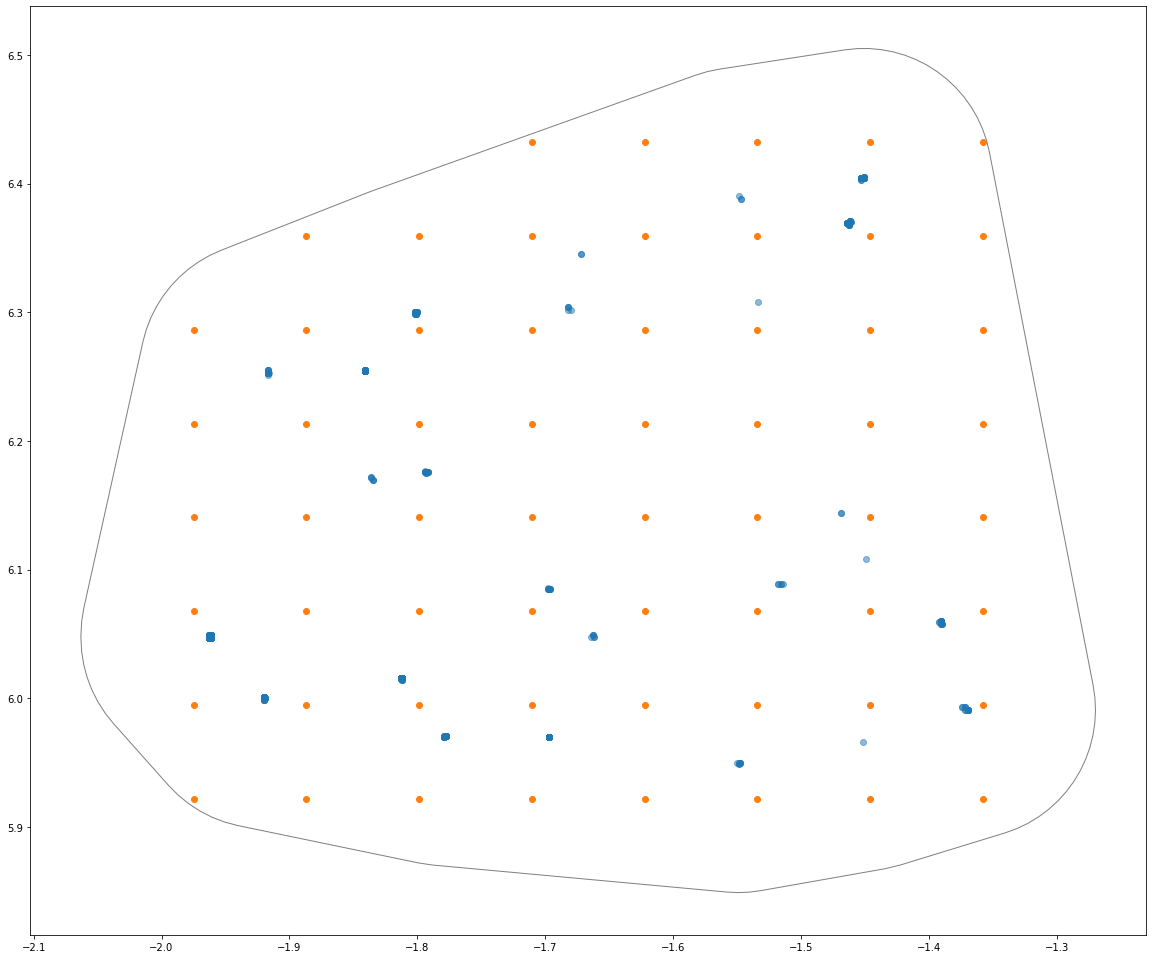

In [50]:
f, ax = plt.subplots(figsize=[20,20])
#Gaardian_outer.plot(ax=ax, color='none', edgecolor='grey')
GaardianGeo.plot(ax=ax, alpha=0.5)
plt.scatter(xs, ys)

In [51]:
coords.tofile("coords.npy")

In [49]:
outer.tofile("outer.npy")

In [52]:
%%time
# setup graph
points = points_from_polygons(Gaardian_outer.geometry)
outer = np.array(points)  # outer coordinates

grid_path = "GhanaDDG.shp" # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coords, 
                                             ggrid=grid_path,
                                             translated=False, 
                                             buffer=0,
                                             outer=outer)

CPU times: user 6.35 s, sys: 0 ns, total: 6.35 s
Wall time: 6.35 s


Lets take a peek at each of these inputs:

In [26]:
coords[:10,:]

array([[-1.682,  6.302],
       [-1.801,  6.299],
       [-1.801,  6.299],
       [-1.801,  6.299],
       [-1.841,  6.254],
       [-1.841,  6.255],
       [-1.841,  6.255],
       [-1.841,  6.255],
       [-1.841,  6.255],
       [-1.841,  6.255]])

In [27]:
outer[:5, ]

array([[-1.53173734,  5.85050127],
       [-1.54047903,  5.8493637 ],
       [-1.54928693,  5.84900041],
       [-1.55809261,  5.84941424],
       [-1.78809261,  5.87041424]])

In [28]:
edges[:5, ]

array([[1577, 1578],
       [1687, 1688],
       [1114, 1115],
       [ 898,  899],
       [1508, 1509]])

In [29]:
grid[:5, ]

array([[-1.775,  5.922],
       [-1.776,  5.902],
       [-1.779,  5.883],
       [-2.051,  6.107],
       [-2.033,  6.113]])

## Setup the `SpatialGraph` object

We then setup the `SpatialGraph` object which is the core workhorse of `feems`. `SpatialGraph` specifies the graph, allele frequency data, and runs the optimizers to fit the edge weights of the graph:

In [53]:
%%time
sp_graph = SpatialGraph(genotypes, coords, grid, edges, scale_snps=True)

/home/sanj/projects/gaardian/notebooks/feems/spatial_graph.py:81: RuntimeWarning: divide by zero encountered in true_divide
  self.frequencies = self.frequencies / np.sqrt(self.mu * (1 - self.mu))


CPU times: user 22.8 s, sys: 966 ms, total: 23.8 s
Wall time: 23.8 s


This might take a few minutes to construct at first b/c it initializing a number of graph matrices that are slow to build. First, before any fitting we'll visualize the graph and samples. Lets setup the projection we'll be using for this dataset:

In [29]:
projection = ccrs.EquidistantConic(central_longitude=-6, central_latitude=-1.8)

Now lets make a map of the sample coordinates, graph and observed nodes:

/home/sanj/apps/anaconda3/envs/feems_e/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/sanj/apps/anaconda3/envs/feems_e/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/sanj/apps/anaconda3/envs/feems_e/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/sanj/apps/anaconda3

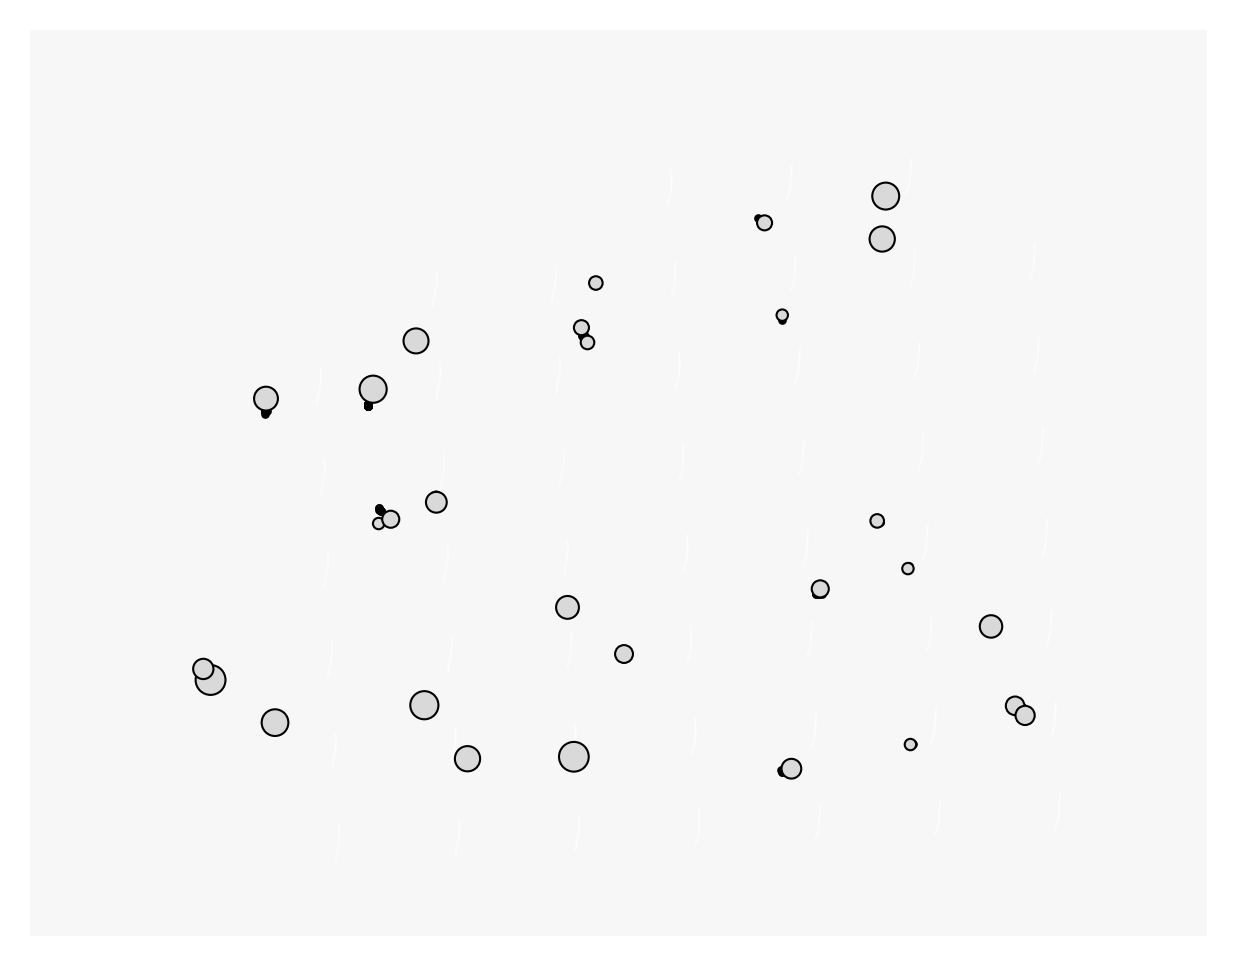

In [30]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_samples()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)

The black points are the observed locations for each sample and the gray points show the nodes that samples were assigned to. The gray lines represent the graph that will be fitted.

## Fit `feems`

Next we fit a the `feems` model where we allow a weight to be estimated for every edge, which is encoded in a large adjacency matrix $\mathbf{W}$, while encouraging nearby edges to be smooth. We initialize at the fit from the null model and fix the estimate of the residual variance for the more complex optimization:

In [54]:
%%time
sp_graph.fit(lamb = 20.0)

CholmodNotPositiveDefiniteError: ../Cholesky/t_cholmod_rowfac.c:430: not positive definite (code 1)

Now we can visualize the weighted graph:

ValueError: Received invalid argument(s): edge_norm

/home/sanj/apps/anaconda3/envs/feems_e/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/sanj/apps/anaconda3/envs/feems_e/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/sanj/apps/anaconda3/envs/feems_e/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)

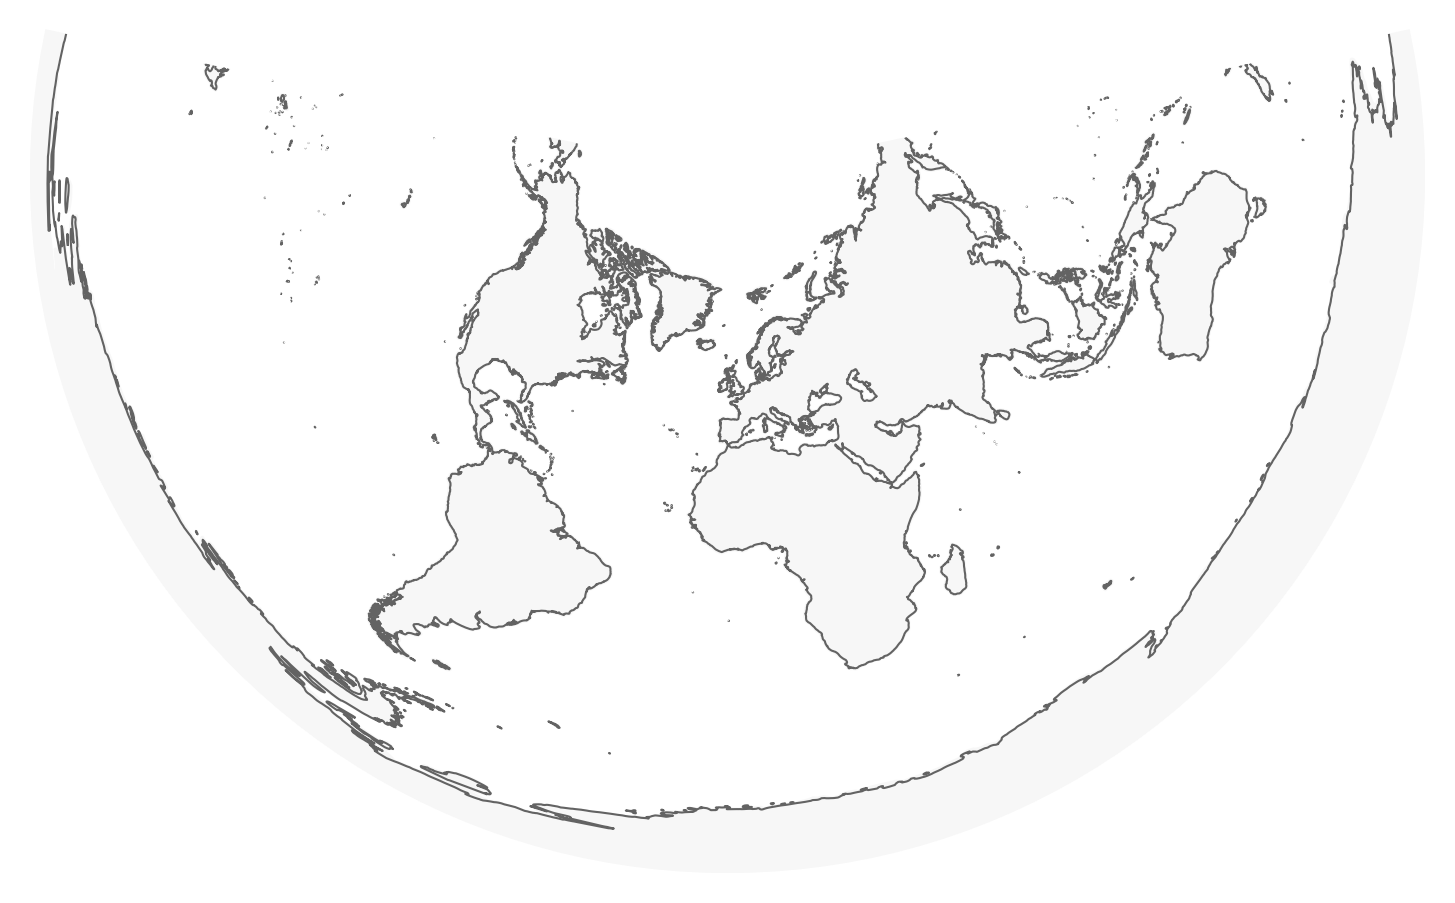

In [67]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

Lets now try a different regularization setting that isn't as smooth:

In [68]:
%%time
sp_graph.fit(lamb = 2.0)

CholmodNotPositiveDefiniteError: ../Cholesky/t_cholmod_rowfac.c:430: not positive definite (code 1)

Make the viz:

ValueError: Received invalid argument(s): edge_norm

/home/sanj/apps/anaconda3/envs/feems_e/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/sanj/apps/anaconda3/envs/feems_e/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/sanj/apps/anaconda3/envs/feems_e/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)

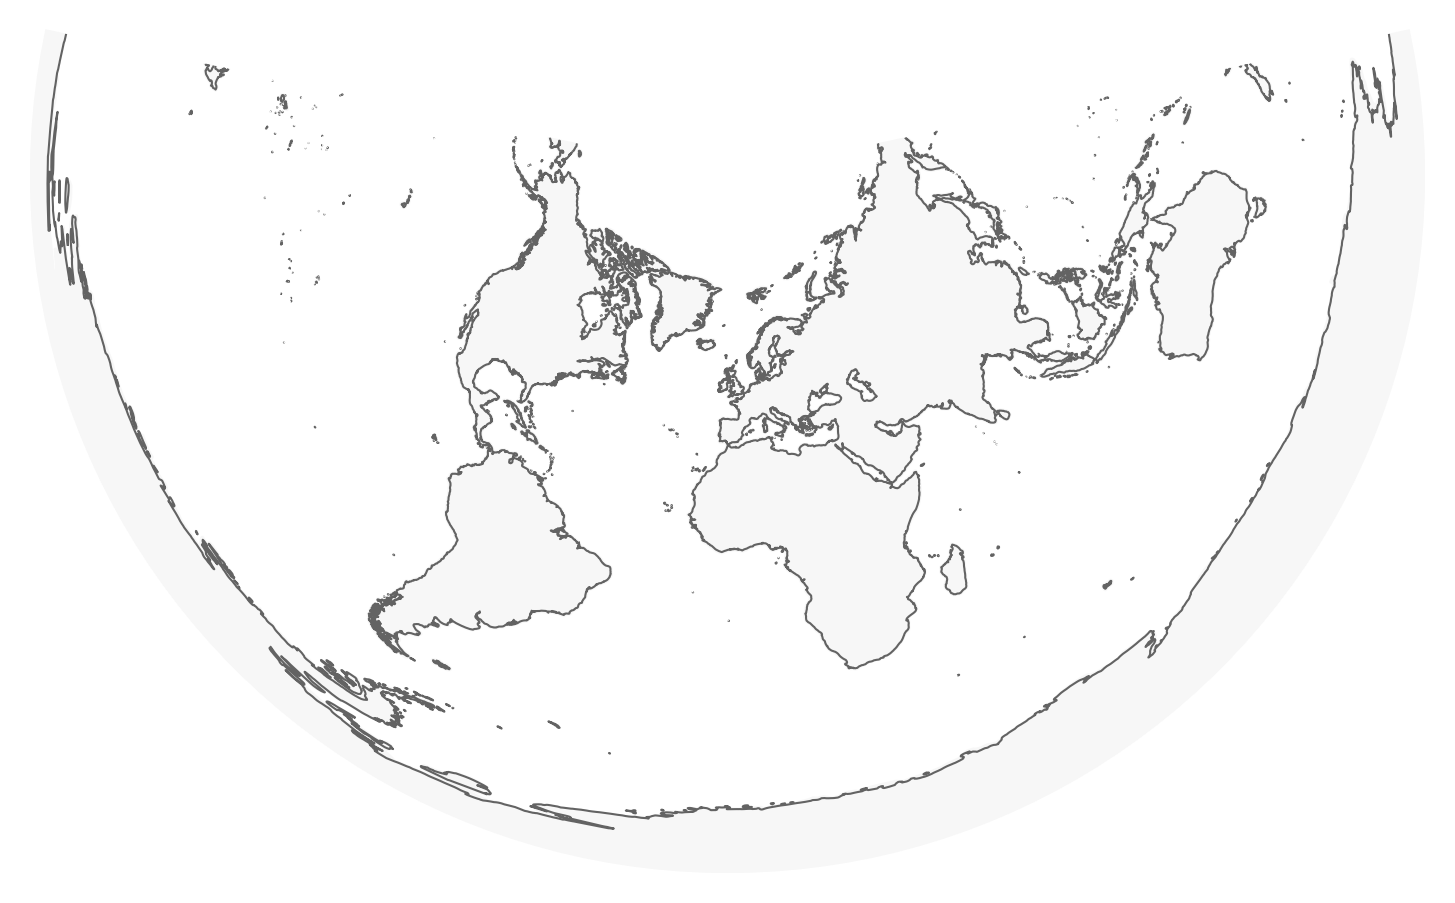

In [69]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

Great ... now we see our first `feems` plot! We essentially provided these results interactively! For more interpretation of these  figures and method please see our pre-print :)